In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import bz2
from glob import glob
import imageio
import json
import os

In [2]:
!pip install tables

     |████████████████████████████████| 5.9 MB 881 kB/s            


In [3]:
def create_pitch(length, width, linecolor, bounds = 15):

    """
    mainly stolen from fc python
    param length: an int the length of the field
    param width: an int the height of the field
    param linecolor: the color of the lines
"""
    #Create figure
    fig=plt.figure()
    #fig.set_size_inches(7, 5)
    ax=fig.add_subplot(1,1,1)

    #Pitch Outline & Centre Line
    plt.plot([0,0],[0,width], color=linecolor)
    plt.plot([0,length],[width,width], color=linecolor)
    plt.plot([length,length],[width,0], color=linecolor)
    plt.plot([length,0],[0,0], color=linecolor)
    plt.plot([length/2,length/2],[0,width], color=linecolor)
    plt.fill_between(x = [-bounds, length+bounds],
                     y1 = [width+bounds, width + bounds],
                     y2 = [-bounds, -bounds], color='green')

    #Left Penalty Area
    plt.plot([16.5 ,16.5],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
    plt.plot([0,16.5],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
    plt.plot([16.5,0],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)

    #Right Penalty Area
    plt.plot([(length-16.5),length],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
    plt.plot([(length-16.5), (length-16.5)],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
    plt.plot([(length-16.5),length],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)

    #Left 5-meters Box
    plt.plot([0,5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
    plt.plot([5.5,5.5],[(width/2+7.32/2+5.5),(width/2-7.32/2-5.5)],color=linecolor)
    plt.plot([5.5,0.5],[(width/2-7.32/2-5.5),(width/2-7.32/2-5.5)],color=linecolor)

    #Right 5-meters Box
    plt.plot([length,length-5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
    plt.plot([length-5.5,length-5.5],[(width/2+7.32/2+5.5),width/2-7.32/2-5.5],color=linecolor)
    plt.plot([length-5.5,length],[width/2-7.32/2-5.5,width/2-7.32/2-5.5],color=linecolor)

    #Prepare Circles
    centreCircle = plt.Circle((length/2,width/2),9.15,color=linecolor,fill=False)
    centreSpot = plt.Circle((length/2,width/2),0.8,color=linecolor)
    leftPenSpot = plt.Circle((11,width/2),0.8,color=linecolor)
    rightPenSpot = plt.Circle((length-11,width/2),0.8,color=linecolor)

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    leftArc = Arc((11,width/2),height=18.3,width=18.3,angle=0,theta1=308,theta2=52,color=linecolor)
    rightArc = Arc((length-11,width/2),height=18.3,width=18.3,angle=0,theta1=128,theta2=232,color=linecolor)

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
            #Axis titles
    #Tidy Axes
    plt.axis('off')
    
    return fig,ax

In [4]:
data_path = '../input/socceranalytics/events/events/'
team = 'Italy'
json_matches_path = '../input/socceranalytics/matches.json'

def all_matches(team, data_path):
    match_ids = get_all_matchids(team)
    all_team_df, dfs = get_all_matchdfs(match_ids, data_path)
    return all_team_df, dfs

def get_all_matchids(team):
    '''
    given a team name i.e. "Italy", returns a list of all match_ids by italy
    '''
    with open(json_matches_path) as f:
        data = json.load(f)
        matches = pd.json_normalize(data, sep = "_")
    #get mask for team
    mask = (matches["home_team_home_team_name"] == team) | (matches["away_team_away_team_name"] == team)
    team_matches = matches[mask]
    match_ids = []
    for match in team_matches.match_id:
        match_ids.append(match)
    return match_ids

def get_all_matchdfs(match_ids, data_path):
    '''
    takes a list of matches and a datapath to all match_data and returns
    a concatenated dataframe + a dictionary of dataframes 
    with all dataframes for those match_ids
    param: match_ids, list of strings match_ids
    param: data_path, string, path to json files
    '''
    dfs = dict()
    for match_id in match_ids:
        zipfile = bz2.BZ2File(data_path + f"{match_id}.json.bz2")
        file = zipfile.read()
        open(f"{match_id}.json", 'wb').write(file)
        with open(f"{match_id}.json") as f:
            events = json.load(f)
            df = pd.json_normalize(events[2:], sep = "_")
            df['match_id'] = match_id
            dfs[match_id] = df
    match_dfs = []
    for key, df in dfs.items():
        match_dfs.append(df)
    return pd.concat(match_dfs), dfs

In [5]:
all_italy_df, dfs = all_matches('Italy', data_path)

In [6]:
dfs.keys()

dict_keys([3795107, 3795506, 3794685, 3788766, 3788754, 3788741, 3795220])

In [7]:
all_italy_df

,id,index,period,timestamp,minute,second,possession,duration,related_events,type_id,...,shot_open_goal,injury_stoppage_in_chain,goalkeeper_penalty_saved_to_post,ball_recovery_offensive,dribble_no_touch,shot_redirect,goalkeeper_lost_in_play,clearance_other,goalkeeper_punched_out,block_offensive
0,64bccdb6-faa1-4aae-9aa0-056865cad782,3,1,00:00:00.000,0,0,1,0.000000,[d636cade-7a3a-45ce-85b1-feaf7ad13d22],18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,d636cade-7a3a-45ce-85b1-feaf7ad13d22,4,1,00:00:00.000,0,0,1,0.000000,[64bccdb6-faa1-4aae-9aa0-056865cad782],18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,38fb7d93-2a97-4e63-8254-9abd38654e3a,5,1,00:00:01.215,0,1,2,0.756320,[44c7909f-0b7f-422d-8bbb-9cab485f8ce0],30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44c7909f-0b7f-422d-8bbb-9cab485f8ce0,6,1,00:00:01.971,0,1,2,NaN,[38fb7d93-2a97-4e63-8254-9abd38654e3a],42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,087a5f90-821b-4639-8ad6-2385de099bce,7,1,00:00:01.971,0,1,2,0.730048,"[44c7909f-0b7f-422d-8bbb-9cab485f8ce0, d884d89...",43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4820,e4cd07aa-5f91-4a40-823a-51b7b32e2a89,4823,5,00:05:03.342,125,3,277,0.000000,[13cddce3-c0e7-483e-b281-67116ca296b9],23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4821,5deaa8a6-916a-4f1b-a7dd-a4dd44111084,4824,5,00:06:00.474,126,0,278,0.622553,[2d72f23a-52bb-4956-a126-fc06cb6dc8c9],16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4822,2d72f23a-52bb-4956-a126-fc06cb6dc8c9,4825,5,00:06:01.097,126,1,278,0.000000,[5deaa8a6-916a-4f1b-a7dd-a4dd44111084],23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4823,aedb49e2-37a9-4901-9e0e-c2885cacb611,4826,5,00:06:03.601,126,3,278,0.000000,[0bb331b7-3c05-4a4f-892d-b1508d32f080],34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
all_italy_df

,id,index,period,timestamp,minute,second,possession,duration,related_events,type_id,...,shot_open_goal,injury_stoppage_in_chain,goalkeeper_penalty_saved_to_post,ball_recovery_offensive,dribble_no_touch,shot_redirect,goalkeeper_lost_in_play,clearance_other,goalkeeper_punched_out,block_offensive
0,64bccdb6-faa1-4aae-9aa0-056865cad782,3,1,00:00:00.000,0,0,1,0.000000,[d636cade-7a3a-45ce-85b1-feaf7ad13d22],18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,d636cade-7a3a-45ce-85b1-feaf7ad13d22,4,1,00:00:00.000,0,0,1,0.000000,[64bccdb6-faa1-4aae-9aa0-056865cad782],18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,38fb7d93-2a97-4e63-8254-9abd38654e3a,5,1,00:00:01.215,0,1,2,0.756320,[44c7909f-0b7f-422d-8bbb-9cab485f8ce0],30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44c7909f-0b7f-422d-8bbb-9cab485f8ce0,6,1,00:00:01.971,0,1,2,NaN,[38fb7d93-2a97-4e63-8254-9abd38654e3a],42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,087a5f90-821b-4639-8ad6-2385de099bce,7,1,00:00:01.971,0,1,2,0.730048,"[44c7909f-0b7f-422d-8bbb-9cab485f8ce0, d884d89...",43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4820,e4cd07aa-5f91-4a40-823a-51b7b32e2a89,4823,5,00:05:03.342,125,3,277,0.000000,[13cddce3-c0e7-483e-b281-67116ca296b9],23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4821,5deaa8a6-916a-4f1b-a7dd-a4dd44111084,4824,5,00:06:00.474,126,0,278,0.622553,[2d72f23a-52bb-4956-a126-fc06cb6dc8c9],16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4822,2d72f23a-52bb-4956-a126-fc06cb6dc8c9,4825,5,00:06:01.097,126,1,278,0.000000,[5deaa8a6-916a-4f1b-a7dd-a4dd44111084],23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4823,aedb49e2-37a9-4901-9e0e-c2885cacb611,4826,5,00:06:03.601,126,3,278,0.000000,[0bb331b7-3c05-4a4f-892d-b1508d32f080],34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
with open('../input/socceranalytics/matches.json') as f:
    data = json.load(f)
    matches = pd.json_normalize(data, sep = "_")
    
to_drop = ['away_team_away_team_gender',
           'home_team_home_team_gender',
           'competition_country_name',
           'competition_competition_id',
           'last_updated_360',
           'last_updated',
           'season_season_name',
           'competition_competition_name',
           'competition_competition_id',
           'match_status',
           'metadata_shot_fidelity_version',
           'match_week']
matches = matches.drop(to_drop, axis=1)

In [10]:
matches.shape

(51, 31)

In [11]:
#drop 0 variance columns
matches.loc[:, (matches != matches.iloc[0]).any()].shape

(51, 27)

In [12]:
mask = (matches["home_team_home_team_name"] == "Italy") | (matches["away_team_away_team_name"] == "Italy")
italy_matches = matches[mask]
mask = (matches["home_team_home_team_name"] == "Wales") | (matches["away_team_away_team_name"] == "Wales")
wales_matches = matches[mask]

In [13]:
italy_match_ids = []
wales_match_ids = []
for match in italy_matches.match_id:
    italy_match_ids.append(match)
for match in wales_matches.match_id:
    wales_match_ids.append(match)

In [14]:
data_path = '../input/socceranalytics/events/events'
files = glob(data_path +'/*.json.bz2')

In [15]:
os.mkdir('selected_matchs')

In [16]:
dfs = dict()
for match_id in italy_match_ids:
    zipfile = bz2.BZ2File(f"../input/socceranalytics/events/events/{match_id}.json.bz2")
    file = zipfile.read()
    open(f"{match_id}.json", 'wb').write(file)
    with open(f"{match_id}.json") as f:
        events = json.load(f)
        df = pd.json_normalize(events[2:], sep = "_")
        df['match_id'] = match_id
        dfs[match_id] = df


In [17]:
italy_match_dfs = []
for key, df in dfs.items():
    italy_match_dfs.append(df)

In [18]:
all_italy_df = pd.concat(italy_match_dfs)

In [19]:
all_italy_df.sort_values(by = 'timestamp').tail()

,id,index,period,timestamp,minute,second,possession,duration,related_events,type_id,...,shot_open_goal,injury_stoppage_in_chain,goalkeeper_penalty_saved_to_post,ball_recovery_offensive,dribble_no_touch,shot_redirect,goalkeeper_lost_in_play,clearance_other,goalkeeper_punched_out,block_offensive
3603,ae1e9245-b348-4391-9854-75e4ae991ce6,3606,2,00:51:33.388,96,33,154,2.385979,[0d77a37c-a494-48b4-835c-95b9fbdd2c65],30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3602,0d77a37c-a494-48b4-835c-95b9fbdd2c65,3605,2,00:51:33.388,96,33,154,0.000000,[ae1e9245-b348-4391-9854-75e4ae991ce6],4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3601,1f7525e0-b674-459f-8fc8-a0469ee13d6a,3604,2,00:51:33.388,96,33,154,NaN,[edbbf0ac-cf68-4481-bf73-20e50a09e26d],42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3605,c7c9fc54-919d-4894-96b4-9eb0be44627a,3608,2,00:52:02.331,97,2,154,0.000000,[2e0296bb-5e22-4d62-b5cf-e8bbeadb23f4],34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3604,2e0296bb-5e22-4d62-b5cf-e8bbeadb23f4,3607,2,00:52:02.331,97,2,154,0.000000,[c7c9fc54-919d-4894-96b4-9eb0be44627a],34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
all_italy_df.sample(5)['match_id']

3285    3788741
1058    3795107
1931    3794685
1475    3795107
180     3795220
Name: match_id, dtype: int64

In [21]:
bins = [i for i in range(0, 130, 5)]
all_italy_df['minute_bins'] = pd.cut(all_italy_df.minute + 1, bins = bins, labels = bins.append(130), retbins = True)[0].apply(lambda x: x.right)

In [22]:
all_italy_df.minute_bins

0         5
1         5
2         5
3         5
4         5
       ... 
4820    130
4821    130
4822    130
4823    130
4824    130
Name: minute_bins, Length: 28869, dtype: category
Categories (26, int64): [5 < 10 < 15 < 20 ... 115 < 120 < 125 < 130]

In [23]:
def time_to_mins(timestring):
    minute = list(map(float, timestring.split(":")))[1]
    return minute

In [24]:
all_italy_df['minute']

0         0
1         0
2         0
3         0
4         0
       ... 
4820    125
4821    126
4822    126
4823    126
4824    126
Name: minute, Length: 28869, dtype: int64

In [25]:
for index, col in enumerate(all_italy_df.columns):
    print(index, col)

0 id
1 index
2 period
3 timestamp
4 minute
5 second
6 possession
7 duration
8 related_events
9 type_id
10 type_name
11 possession_team_id
12 possession_team_name
13 play_pattern_id
14 play_pattern_name
15 team_id
16 team_name
17 location
18 player_id
19 player_name
20 position_id
21 position_name
22 pass_recipient_id
23 pass_recipient_name
24 pass_length
25 pass_angle
26 pass_height_id
27 pass_height_name
28 pass_end_location
29 pass_body_part_id
30 pass_body_part_name
31 pass_type_id
32 pass_type_name
33 carry_end_location
34 under_pressure
35 pass_outcome_id
36 pass_outcome_name
37 ball_receipt_outcome_id
38 ball_receipt_outcome_name
39 clearance_head
40 clearance_body_part_id
41 clearance_body_part_name
42 pass_aerial_won
43 duel_type_id
44 duel_type_name
45 counterpress
46 dribble_outcome_id
47 dribble_outcome_name
48 goalkeeper_outcome_id
49 goalkeeper_outcome_name
50 goalkeeper_type_id
51 goalkeeper_type_name
52 duel_outcome_id
53 duel_outcome_name
54 off_camera
55 pass_assisted_

In [26]:
all_italy_df.timestamp.sort_values()

0       00:00:00.000
4340    00:00:00.000
4341    00:00:00.000
0       00:00:00.000
1       00:00:00.000
            ...     
3603    00:51:33.388
3602    00:51:33.388
3601    00:51:33.388
3605    00:52:02.331
3604    00:52:02.331
Name: timestamp, Length: 28869, dtype: object

In [27]:
italian_shots = all_italy_df[(all_italy_df.type_name == 'Shot') & (all_italy_df.possession_team_name == 'Italy')]
shots_against_italy = all_italy_df[(all_italy_df.type_name == 'Shot') & (all_italy_df.possession_team_name != 'Italy')]
shots_i = all_italy_df[(all_italy_df.type_name == 'Shot')]

In [28]:
shots_i['shot_outcome_name'].unique()

array(['Blocked', 'Wayward', 'Saved', 'Off T', 'Goal', 'Saved Off Target',
       'Saved to Post', 'Post'], dtype=object)

In [29]:
italian_shots.groupby('player_name').sum()

,index,period,minute,second,possession,duration,type_id,possession_team_id,play_pattern_id,team_id,...,50_50_outcome_id,foul_committed_card_id,goalkeeper_body_part_id,goalkeeper_technique_id,substitution_outcome_id,substitution_replacement_id,tactics_formation,bad_behaviour_card_id,match_id,foul_committed_type_id
player_name,,,,,,,,,,,,,,,,,,,,,
Andrea Belotti,35478,32,899,277,1756,7.915388,176,10054,35,10054,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41714938,0.0
Bryan Cristante,7724,6,211,9,362,0.959658,32,1828,6,1828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7584272,0.0
Cengiz Ünder,2205,2,50,58,123,0.094442,16,914,3,909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3788741,0.0
Ciro Immobile,35571,27,811,642,1618,14.401713,288,16452,54,16452,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68247564,0.0
Domenico Berardi,35209,28,825,464,1757,9.041088,240,13710,46,13710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56881953,0.0
Emerson Palmieri dos Santos,4840,4,125,26,240,1.680330,48,2742,5,2742,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11372752,0.0
Federico Bernardeschi,19600,19,509,136,998,4.220980,96,5484,18,5484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22752530,0.0
Federico Chiesa,34863,28,865,399,1700,8.135483,256,14624,52,14624,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60696927,0.0
Ferrán Torres García,737,1,14,14,27,0.863837,16,914,4,772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3795220,0.0


In [30]:
italian_shots.player_name.value_counts()

Lorenzo Insigne                19
Ciro Immobile                  18
Federico Chiesa                16
Domenico Berardi               15
Andrea Belotti                 11
Leonardo Spinazzola             7
Leonardo Bonucci                7
Federico Bernardeschi           6
Manuel Locatelli                6
Giovanni Di Lorenzo             5
Nicolò Barella                  5
Marco Verratti                  4
Matteo Pessina                  4
Emerson Palmieri dos Santos     3
Bryan Cristante                 2
Jorge Luiz Frello Filho         2
Rafael Tolói                    2
Giorgio Chiellini               2
Francesco Acerbi                1
Marcel Sabitzer                 1
Giacomo Raspadori               1
Cengiz Ünder                    1
Ferrán Torres García            1
Name: player_name, dtype: int64

In [31]:
italian_shots.player_name.value_counts()

Lorenzo Insigne                19
Ciro Immobile                  18
Federico Chiesa                16
Domenico Berardi               15
Andrea Belotti                 11
Leonardo Spinazzola             7
Leonardo Bonucci                7
Federico Bernardeschi           6
Manuel Locatelli                6
Giovanni Di Lorenzo             5
Nicolò Barella                  5
Marco Verratti                  4
Matteo Pessina                  4
Emerson Palmieri dos Santos     3
Bryan Cristante                 2
Jorge Luiz Frello Filho         2
Rafael Tolói                    2
Giorgio Chiellini               2
Francesco Acerbi                1
Marcel Sabitzer                 1
Giacomo Raspadori               1
Cengiz Ünder                    1
Ferrán Torres García            1
Name: player_name, dtype: int64

In [32]:
sns.set(rc={'figure.figsize':(15,10)})
length = 105
width = 68

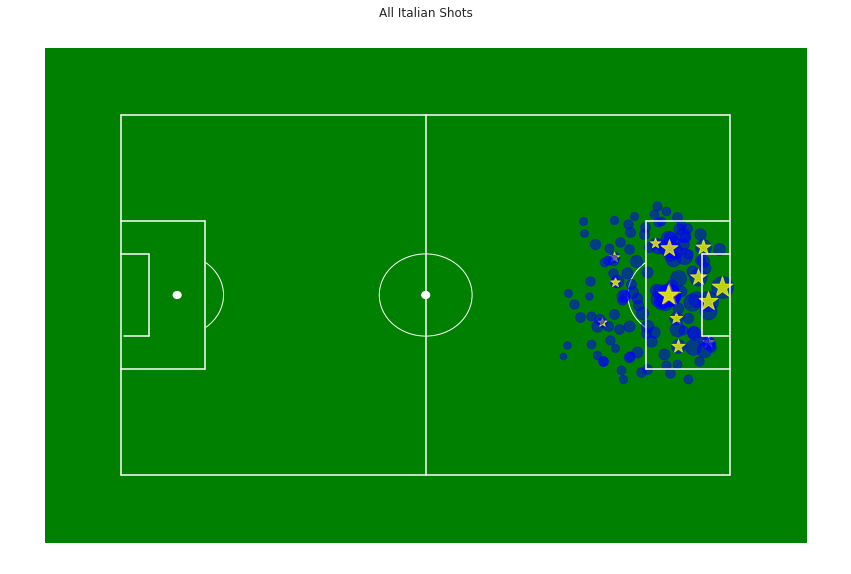

In [33]:
fig, ax = create_pitch(120, 80,'white')
for index, shot in italian_shots.iterrows():
    x, y = shot['location']
    team = shot['possession_team_name']
    if team == 'Italy':
        color = 'blue'
    else:
        color = 'red'
        x = abs(length - x)
    y = 80 - y
    size=np.sqrt(shot['shot_statsbomb_xg'])*500
    if shot['shot_outcome_name'] == "Goal":
        #plt.text((x+1),width-y+1,shot['player_name'], color = "white")
        plt.scatter(x,y, marker = 'o', color = color, s = size, alpha = 0.5)
        plt.scatter(x,y, marker = '*', color = 'yellow', s = size, alpha = 0.75)
    else:
        plt.scatter(x,y, marker = 'o', color = color, s = size, alpha = 0.5)
#plt.legend(['Italy', 'Wales'], fontsize = 'x-large')
plt.title("All Italian Shots")
leg = ax.get_legend()
# leg.legendHandles[0].set_color('blue')
# leg.legendHandles[1].set_color('red')
    #shotCircle = plt.Circle((x,y) , 2, color="red")     
    #ax.add_patch(shotCircle)
plt.savefig("allitaly_shots.png")
plt.show()

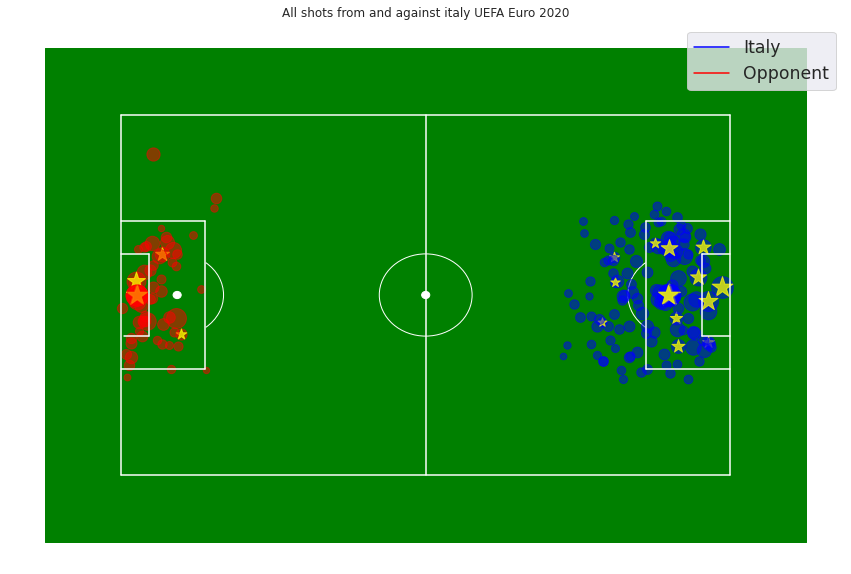

In [34]:
fig, ax = create_pitch(120, 80,'white')
for index, shot in shots_i.iterrows():
#     if shot['shot_outcome_name'] != "Goal":
#         continue
    x, y = shot['location']
    team = shot['possession_team_name']
    if team == 'Italy':
        color = 'blue'
    else:
        color = 'red'
        x = abs(length - x)
        
    
    y = 80 - y
    size=np.sqrt(shot['shot_statsbomb_xg'])*500
    if shot['shot_outcome_name'] == "Goal":
        #plt.text((x+1),width-y+1,shot['player_name'], color = "white")
        plt.scatter(x,y, marker = 'o', color = color, s = size, alpha = 0.5)
        plt.scatter(x,y, marker = '*', color = 'yellow', s = size, alpha = 0.75)
    else:
        plt.scatter(x,y, marker = 'o', color = color, s = size, alpha = 0.5)
plt.legend(['Italy', 'Opponent'], fontsize='x-large')
plt.title("All shots from and against italy UEFA Euro 2020")
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')
#     if shot['shot_outcome_name'] == "Goal":
#         plt.text((x+1),width-y+1,shot['player_name'], color = 'white') 
    #shotCircle = plt.Circle((x,y) , 2, color="red")     
    #ax.add_patch(shotCircle)
plt.savefig("all_italy_opp2.png")
plt.show()

In [35]:
goal=shots_i['shot_outcome_name']=='Goal'
shots_i[goal]['player_name'].value_counts()

Leonardo Bonucci                  3
Federico Chiesa                   2
Manuel Locatelli                  2
Ciro Immobile                     2
Federico Bernardeschi             2
Lorenzo Insigne                   2
Matteo Pessina                    2
Thiago Alcântara do Nascimento    1
Gerard Moreno Balaguero           1
Andrea Belotti                    1
Álvaro Borja Morata Martín        1
Nicolò Barella                    1
Sasa Kalajdzic                    1
Harry Maguire                     1
Harry Kane                        1
Domenico Berardi                  1
Luke Shaw                         1
Romelu Lukaku Menama              1
Jorge Luiz Frello Filho           1
Name: player_name, dtype: int64

In [36]:
bonucci_goals = shots_i[shots_i.player_name == "Leonardo Bonucci"]

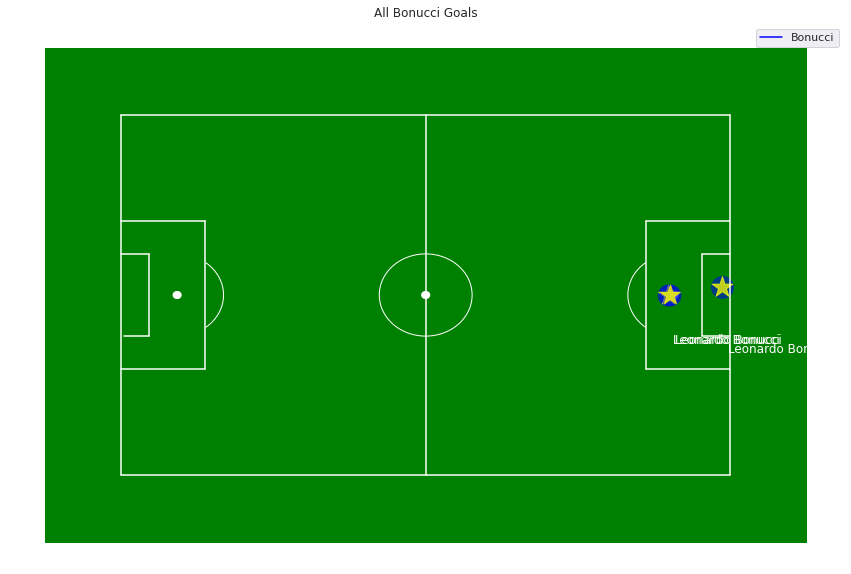

In [37]:
fig, ax = create_pitch(120, 80,'white')
for index, shot in bonucci_goals[bonucci_goals.shot_outcome_name == 'Goal'].iterrows():
    x, y = shot['location']
    team = shot['possession_team_name']
    if team == 'Italy':
        color = 'blue'
    else:
        color = 'red'
        x = abs(length - x)
    y = 80 - y
    size=np.sqrt(shot['shot_statsbomb_xg'])*500
    
    if shot['shot_outcome_name'] == "Goal":
        plt.text((x+1),width-y+1,shot['player_name'], color = "white")
        plt.scatter(x,y, marker = 'o', color = color, s = size, alpha = 0.5)
        plt.scatter(x,y, marker = '*', color = 'yellow', s = size, alpha = 0.75)
    else:
        plt.scatter(x,y, marker = 'o', color = color, s = size, alpha = 0.5)
        
plt.legend(['Bonucci'])
leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
plt.title("All Bonucci Goals")

    #shotCircle = plt.Circle((x,y) , 2, color="red")     
    #ax.add_patch(shotCircle)
plt.savefig("Bonucci.png")
plt.show()

In [38]:
bonucci_goals

,id,index,period,timestamp,minute,second,possession,duration,related_events,type_id,...,injury_stoppage_in_chain,goalkeeper_penalty_saved_to_post,ball_recovery_offensive,dribble_no_touch,shot_redirect,goalkeeper_lost_in_play,clearance_other,goalkeeper_punched_out,block_offensive,minute_bins
1876,b414bbbc-2594-456f-a9a9-861836d6685a,1879,1,00:48:19.914,48,19,80,1.201105,[2ec9ea2f-3fd9-4357-962c-6222cf03c2ae],16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50
2643,a221a567-b43e-45d6-97f2-07b1cab75d21,2646,2,00:21:17.528,66,17,119,0.184356,"[4698d21d-a880-4e18-b30d-888f18aae319, 893ab58...",16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70
4780,f21ac35f-5ca3-4965-bf47-17786bef12ab,4783,5,00:03:17.339,123,17,217,0.478691,[a397386a-71f1-4235-a3db-5441031405ea],16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125
2527,e0357750-de0e-4d2b-8b94-1256f492adc0,2530,2,00:10:45.905,55,45,110,0.713431,"[6ca51f07-ce73-46f0-b510-0dd4f38e7a08, aaddc01...",16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60
883,78eaf3e4-045e-4a62-b5ee-35446c308ff9,886,1,00:19:10.158,19,10,44,1.423567,[0eb7847c-f4e3-406e-820b-3c20315bbc26],16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
936,2cf281d8-3423-41eb-8bf8-c719f2fd63ef,939,1,00:22:04.933,22,4,49,0.499086,[bd3cf713-70a9-4e77-b271-dc6f244af25b],16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25
4813,c972fd58-d9ee-4ab3-9661-d23234195c22,4816,5,00:03:06.893,123,6,274,0.334140,[8817c842-537d-44b5-bb6f-14a9740f0e66],16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125


In [39]:
italy_wales = dfs[3788766]

In [40]:
for col in italy_wales.columns:
    print(col)

id
index
period
timestamp
minute
second
possession
duration
related_events
type_id
type_name
possession_team_id
possession_team_name
play_pattern_id
play_pattern_name
team_id
team_name
location
player_id
player_name
position_id
position_name
pass_recipient_id
pass_recipient_name
pass_length
pass_angle
pass_height_id
pass_height_name
pass_end_location
pass_type_id
pass_type_name
pass_body_part_id
pass_body_part_name
carry_end_location
under_pressure
counterpress
pass_outcome_id
pass_outcome_name
ball_receipt_outcome_id
ball_receipt_outcome_name
duel_type_id
duel_type_name
pass_aerial_won
duel_outcome_id
duel_outcome_name
dribble_outcome_id
dribble_outcome_name
pass_switch
pass_cross
interception_outcome_id
interception_outcome_name
off_camera
clearance_head
clearance_body_part_id
clearance_body_part_name
clearance_aerial_won
out
foul_committed_advantage
foul_won_advantage
pass_assisted_shot_id
pass_shot_assist
shot_statsbomb_xg
shot_end_location
shot_key_pass_id
shot_outcome_id
shot_out

In [41]:
italy_wales.pivot_table(index = "type_name", columns = "possession_team_name", aggfunc = 'sum')

ball_receipt_outcome_id        clearance_body_part_id  \
possession_team_name                   Italy  Wales                  Italy   
type_name                                                                    
Ball Receipt*                          432.0  423.0                    0.0   
Ball Recovery                            0.0    0.0                    0.0   
Block                                    0.0    0.0                    0.0   
Carry                                    0.0    0.0                    0.0   
Clearance                                0.0    0.0                  686.0   
Dispossessed                             0.0    0.0                    0.0   
Dribble                                  0.0    0.0                    0.0   
Dribbled Past                            0.0    0.0                    0.0   
Duel                                     0.0    0.0                    0.0   
Foul Committed                           0.0    0.0                    0.0   
Foul Won                                 0.0    0.0                    0.0   
Goal Keeper                              0.0    0.0                    0.0   
Half End                                 0.0    0.0                    0.0   
Half Start                               0.0    0.0                    0.0   
Injury Stoppage                          0.0    NaN                    0.0   
Interception                             0.0    0.0                    0.0   
Miscontrol                               0.0    0.0                    0.0   
Pass                                     0.0    0.0                    0.0   
Pressure                                 0.0    0.0                    0.0   
Shot                                     0.0    0.0                    0.0   
Substitution                             0.0    0.0                    0.0   
Tactical Shift                           0.0    0.0                    0.0   

                            dribble_outcome_id       duel_outcome_id         \
possession_team_name  Wales              Italy Wales           Italy  Wales   
type_name                                                                     
Ball Receipt*           0.0                0.0   0.0             0.0    0.0   
Ball Recovery           0.0                0.0   0.0             0.0    0.0   
Block                   0.0                0.0   0.0             0.0    0.0   
Carry                   0.0                0.0   0.0             0.0    0.0   
Clearance             638.0                0.0   0.0             0.0    0.0   
Dispossessed            0.0                0.0   0.0             0.0    0.0   
Dribble                 0.0              108.0  42.0             0.0    0.0   
Dribbled Past           0.0                0.0   0.0             0.0    0.0   
Duel                    0.0                0.0   0.0           152.0  174.0   
Foul Committed          0.0                0.0   0.0             0.0    0.0   
Foul Won                0.0                0.0   0.0             0.0    0.0   
Goal Keeper             0.0                0.0   0.0             0.0    0.0   
Half End                0.0                0.0   0.0             0.0    0.0   
Half Start              0.0                0.0   0.0             0.0    0.0   
Injury Stoppage         NaN                0.0   NaN             0.0    NaN   
Interception            0.0                0.0   0.0             0.0    0.0   
Miscontrol              0.0                0.0   0.0             0.0    0.0   
Pass                    0.0                0.0   0.0             0.0    0.0   
Pressure                0.0                0.0   0.0             0.0    0.0   
Shot                    0.0                0.0   0.0             0.0    0.0   
Substitution            0.0                0.0   0.0             0.0    0.0   
Tactical Shift          0.0                0.0   0.0             0.0    0.0   

                     duel_type_id         ... substitution_outcome_id         \
possession_tea

In [42]:
shots = italy_wales[italy_wales['type_name'] == 'Shot']
shot_cols = [col for col in shots.columns if 'shot' in col]

In [43]:
shots = shots[shot_cols + ["possession_team_name"]]

In [44]:
num_italian_shots = shots[shots["possession_team_name"] == 'Italy'].shape[0]
num_wales_shots = shots[shots["possession_team_name"] == 'Wales'].shape[0]

In [45]:
print(f'#italian shots {num_italian_shots}, #wales shots: {num_wales_shots}')

#italian shots 23, #wales shots: 3


In [46]:
shots['shot_outcome_name'].value_counts()

Off T      7
Saved      7
Blocked    7
Wayward    3
Goal       1
Post       1
Name: shot_outcome_name, dtype: int64

In [47]:
shots.pivot_table(index = "possession_team_name", aggfunc='mean')

,shot_body_part_id,shot_outcome_id,shot_statsbomb_xg,shot_technique_id,shot_type_id
possession_team_name,,,,,
Italy,39.173913,98.304348,0.083705,92.782609,85.913043
Wales,37.333333,98.666667,0.153585,93.666667,87.000000


In [48]:
shots.pivot_table(index = "possession_team_name", aggfunc='max')

/opt/conda/lib/python3.7/site-packages/pandas/core/apply.py:577: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  return f(*args, **kwargs)


,shot_body_part_id,shot_body_part_name,shot_deflected,shot_end_location,shot_first_time,shot_outcome_id,shot_outcome_name,shot_redirect,shot_statsbomb_xg,shot_technique_id,shot_technique_name,shot_type_id,shot_type_name
possession_team_name,,,,,,,,,,,,,
Italy,40.0,Right Foot,True,"[120.0, 54.9, 2.4]",True,101.0,Wayward,True,0.313013,95.0,Volley,87.0,Open Play
Wales,38.0,Left Foot,NaN,"[120.0, 40.6, 6.7]",True,100.0,Saved,NaN,0.378296,95.0,Volley,87.0,Open Play


In [49]:
shots.groupby(['possession_team_name', 'shot_outcome_name']).size().unstack(fill_value=0)

shot_outcome_name,Blocked,Goal,Off T,Post,Saved,Wayward
possession_team_name,,,,,,
Italy,7,1,5,1,6,3
Wales,0,0,2,0,1,0


In [50]:
shots.groupby(['possession_team_name', 'shot_body_part_name']).size().unstack(fill_value=0)

shot_body_part_name,Head,Left Foot,Right Foot
possession_team_name,,,
Italy,1,8,14
Wales,2,1,0


In [51]:
shots.groupby(['possession_team_name', 'shot_type_name']).size().unstack(fill_value=0)

shot_type_name,Free Kick,Open Play
possession_team_name,,
Italy,1,22
Wales,0,3


In [52]:
italy_shots = shots[shots['possession_team_name'] == 'Italy']
italy_shots = shots[shots['possession_team_name'] == 'Italy']

In [53]:
locations = shots_i['location'].explode().to_numpy().reshape(-1, 2)

In [54]:
H_Shot=np.histogram2d(locations[:, 0], locations[:, 1], bins=20, range= [[0, 120], [0, 80]])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


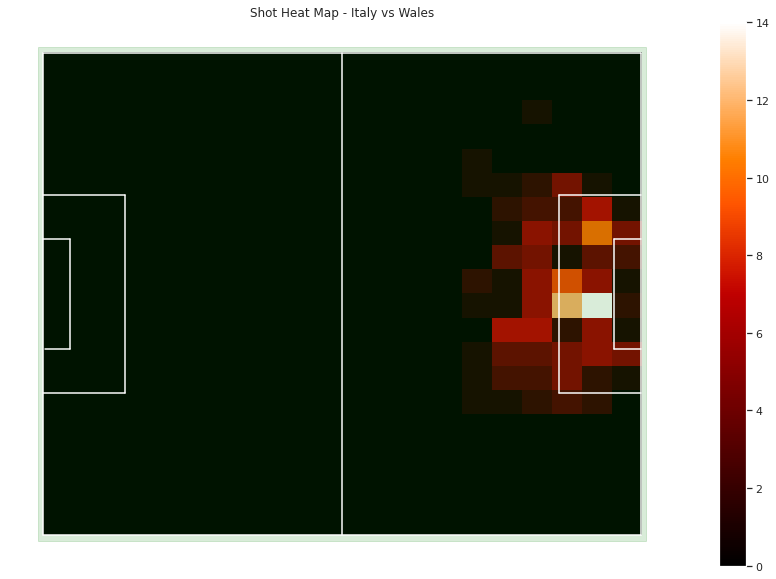

In [55]:

length = 120
width = 80
linecolor = 'white'
bounds = 1

#Pitch Outline & Centre Line
plt.plot([0,0],[0,width], color=linecolor)
plt.plot([0,length],[width,width], color=linecolor)
plt.plot([length,length],[width,0], color=linecolor)
plt.plot([length,0],[0,0], color=linecolor)
plt.plot([length/2,length/2],[0,width], color=linecolor)
plt.fill_between(x = [-bounds, length+bounds],
                 y1 = [width+bounds, width + bounds],
                 y2 = [-bounds, -bounds], color='green', alpha = 0.15)
implot = plt.imshow(H_Shot[0].T, extent = [0,120,0,80], aspect='auto',cmap=plt.cm.gist_heat)


#Left Penalty Area
plt.plot([16.5 ,16.5],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
plt.plot([0,16.5],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
plt.plot([16.5,0],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)

#Right Penalty Area
plt.plot([(length-16.5),length],[(width/2 +16.5),(width/2 +16.5)],color=linecolor)
plt.plot([(length-16.5), (length-16.5)],[(width/2 +16.5),(width/2-16.5)],color=linecolor)
plt.plot([(length-16.5),length],[(width/2 -16.5),(width/2 -16.5)],color=linecolor)

#Left 5-meters Box
plt.plot([0,5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
plt.plot([5.5,5.5],[(width/2+7.32/2+5.5),(width/2-7.32/2-5.5)],color=linecolor)
plt.plot([5.5,0.5],[(width/2-7.32/2-5.5),(width/2-7.32/2-5.5)],color=linecolor)

#Right 5-meters Box
plt.plot([length,length-5.5],[(width/2+7.32/2+5.5),(width/2+7.32/2+5.5)],color=linecolor)
plt.plot([length-5.5,length-5.5],[(width/2+7.32/2+5.5),width/2-7.32/2-5.5],color=linecolor)
plt.plot([length-5.5,length],[width/2-7.32/2-5.5,width/2-7.32/2-5.5],color=linecolor)

#Prepare Circles
centreCircle = plt.Circle((length/2,width/2),9.15,color=linecolor,fill=False)
centreSpot = plt.Circle((length/2,width/2),0.8,color=linecolor)
leftPenSpot = plt.Circle((11,width/2),0.8,color=linecolor)
rightPenSpot = plt.Circle((length-11,width/2),0.8,color=linecolor)

#Draw Circles
ax.add_patch(centreCircle)
ax.add_patch(centreSpot)
ax.add_patch(leftPenSpot)
ax.add_patch(rightPenSpot)

#Prepare Arcs
leftArc = Arc((11,width/2),height=18.3,width=18.3,angle=0,theta1=308,theta2=52,color=linecolor)
rightArc = Arc((length-11,width/2),height=18.3,width=18.3,angle=0,theta1=128,theta2=232,color=linecolor)

#Draw Arcs
ax.add_patch(leftArc)
ax.add_patch(rightArc)
plt.title("Shot Heat Map - Italy vs Wales")
#Tidy Axes
plt.axis('off')
plt.colorbar()
plt.savefig('shot_heatmap.png')
plt.show()


In [56]:
def restore_df(path):
    with pd.HDFStore(path, mode = 'r') as store:
        df = store.get('df')
        df.attrs = store.get_storer('df').attrs.my_attribute
        return df

In [57]:
iw_track = restore_df("../input/socceranalytics/dfmeta/dfmeta/italyvwales.h5")
player_map = iw_track.attrs['player_map']
pos_cols = [col for col in iw_track if 'x' in col or 'y' in col]

In [58]:
for key in player_map.keys():
    try:
        iw_track[str(key) + "_distance"] = (iw_track[str(key) + "_x"] - iw_track['ball_x'])**2
        iw_track[str(key) + "_distance"] += (iw_track[str(key) + "_y"] - iw_track['ball_y'])**2
        iw_track[str(key) + "_distance"] = iw_track[str(key) + "_distance"].apply(np.sqrt)
    except:
        print(f"{player_map[key]} did not play")

Alex Meret did not play
Giovanni Di Lorenzo did not play
Giorgio Chiellini did not play
Leonardo Spinazzola did not play
Alessandro Florenzi did not play
Manuel Locatelli did not play
Nicolò Barella did not play
Lorenzo Insigne did not play
Domenico Berardi did not play
Ciro Immobile did not play
Wayne Hennessey did not play
Adam Davies did not play
Tom Lockyer did not play
Rhys Norrington-Davies did not play
Chris Mepham did not play
Ben Cabango did not play
Jonny Williams did not play
Rubin Colwill did not play
Matthew Smith did not play
Tyler Roberts did not play


In [59]:
d2ball = [col for col in iw_track.columns if 'distance' in col]
iw_track[d2ball] = iw_track[d2ball].fillna(9999999)

In [60]:
touches = iw_track[d2ball].idxmin(axis=1).value_counts()
for player in touches.keys():
    player_id = player.split("_")[0]
    print(f"{player_map[player_id]} had the ball {touches[player]} frames")
    #25 frames per second
    print(f"{player_map[player_id]} had the ball for {touches[player] / 25} seconds")

Danny Ward had the ball 16851 frames
Danny Ward had the ball for 674.04 seconds
Marco Verratti had the ball 16074 frames
Marco Verratti had the ball for 642.96 seconds
Connor Roberts had the ball 9310 frames
Connor Roberts had the ball for 372.4 seconds
Alessandro Bastoni had the ball 7826 frames
Alessandro Bastoni had the ball for 313.04 seconds
Federico Bernardeschi had the ball 6810 frames
Federico Bernardeschi had the ball for 272.4 seconds
Leonardo Bonucci had the ball 6768 frames
Leonardo Bonucci had the ball for 270.72 seconds
Aaron Ramsey had the ball 6305 frames
Aaron Ramsey had the ball for 252.2 seconds
Francesco Acerbi had the ball 6114 frames
Francesco Acerbi had the ball for 244.56 seconds
Rafael Tolói had the ball 5951 frames
Rafael Tolói had the ball for 238.04 seconds
Daniel James had the ball 5559 frames
Daniel James had the ball for 222.36 seconds
Emerson had the ball 5472 frames
Emerson had the ball for 218.88 seconds
Federico Chiesa had the ball 5236 frames
Federic

In [61]:
p_name = {str(key) + "_distance": value for key, value in player_map.items()}
touches = pd.DataFrame(touches, columns = ["frames"]).rename(index = p_name)

In [62]:
touches['seconds'] = touches['frames'] / 25

In [63]:
touches

,frames,seconds
Danny Ward,16851,674.04
Marco Verratti,16074,642.96
Connor Roberts,9310,372.40
Alessandro Bastoni,7826,313.04
Federico Bernardeschi,6810,272.40
Leonardo Bonucci,6768,270.72
Aaron Ramsey,6305,252.20
Francesco Acerbi,6114,244.56
Rafael Tolói,5951,238.04
Daniel James,5559,222.36
